In [52]:
%load_ext autoreload
%autoreload 2

import torch
from utils import load_ckpt, visualize_depth
from collections import defaultdict
import matplotlib.pyplot as plt
import time

from models.rendering import *
from models.nerf import *

import metrics

from datasets import dataset_dict

torch.backends.cudnn.benchmark = True

img_wh = (400, 400)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# #Test ocllusion dataset
# perturbation = ['occ']

# dataset = dataset_dict['blender'] \
#           ('/home/zt16/code/priv-nerf/nerf-pytorch/data/NeRF_Data/nerf_synthetic/lego/',
#            split='train',
#            perturbation=perturbation,
#            img_wh=img_wh,random_occ=False,yaw_threshold=50.0)

In [102]:
# dataset_2 = dataset_dict['blender'] \
#           ('/home/zt16/code/priv-nerf/nerf-pytorch/data/NeRF_Data/nerf_synthetic/lego/',
#            split='test_train',
#            perturbation=perturbation,
#            img_wh=img_wh,random_occ=False,yaw_threshold=50.0)

In [103]:
# # sample an image ...
# # 0 is unperturbed, others are perturbed
# sample = dataset_2[7]
# rays = sample['rays'].cuda()
# ts = sample['ts'].cuda()

# img_gt = sample['rgbs'].view(img_wh[1], img_wh[0], 3)

# plt.imshow(img_gt)


In [158]:
# Change to your settings...
############################
encode_appearance = False
N_a = 48
encode_transient = True
N_tau = 16
beta_min = 0.1
ckpt_path = 'ckpts/lego_nerfU_occlu_roll_yaw50deg_try2/epoch=19.ckpt'

N_samples = 64
N_importance = 64
use_disp = False
chunk = 1024*32
#############################

embedding_xyz = PosEmbedding(9, 10)
embedding_dir = PosEmbedding(3, 4)
embeddings = {'xyz': embedding_xyz, 'dir': embedding_dir}
if encode_appearance:
    embedding_a = torch.nn.Embedding(100, N_a).cuda()
    load_ckpt(embedding_a, ckpt_path, model_name='embedding_a')
    embeddings['a'] = embedding_a
if encode_transient:
    embedding_t = torch.nn.Embedding(100, N_tau).cuda()
    load_ckpt(embedding_t, ckpt_path, model_name='embedding_t')
    embeddings['t'] = embedding_t
    

nerf_coarse = NeRF('coarse').cuda()
nerf_fine = NeRF('fine',
                 encode_appearance=encode_appearance,
                 in_channels_a=N_a,
                 encode_transient=encode_transient,
                 in_channels_t=N_tau,
                 beta_min=beta_min).cuda()

load_ckpt(nerf_coarse, ckpt_path, model_name='nerf_coarse')
load_ckpt(nerf_fine, ckpt_path, model_name='nerf_fine')

models = {'coarse': nerf_coarse, 'fine': nerf_fine}

In [159]:
@torch.no_grad()
def f(rays, ts):
    """Do batched inference on rays using chunk."""
    B = rays.shape[0]
    results = defaultdict(list)
    for i in range(0, B, chunk):
        rendered_ray_chunks = \
            render_rays(models,
                        embeddings,
                        rays[i:i+chunk],
                        ts[i:i+chunk],
                        N_samples,
                        use_disp,
                        0,
                        0,
                        N_importance,
                        chunk,
                        dataset.white_back,
                        test_time=True)

        for k, v in rendered_ray_chunks.items():
            results[k] += [v]

    for k, v in results.items():
        results[k] = torch.cat(v, 0)
    return results

# Test on (perturbed) train images

In [160]:
perturbation = ['occ']

dataset = dataset_dict['blender'] \
          ('/home/zt16/code/priv-nerf/nerf-pytorch/data/NeRF_Data/nerf_synthetic/lego/',
           split='test_train',
           perturbation=perturbation,
           img_wh=img_wh,random_occ=False,yaw_threshold=50.0)

In [163]:
# sample an image ...
# 0 is unperturbed, others are perturbed
sample = dataset[6]
rays = sample['rays'].cuda()
ts = sample['ts'].cuda()

results = f(rays, ts)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


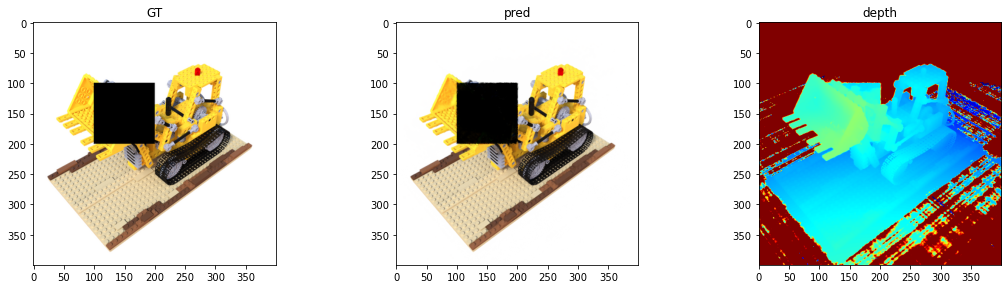

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR between GT and pred: 34.591487884521484 

Decomposition-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


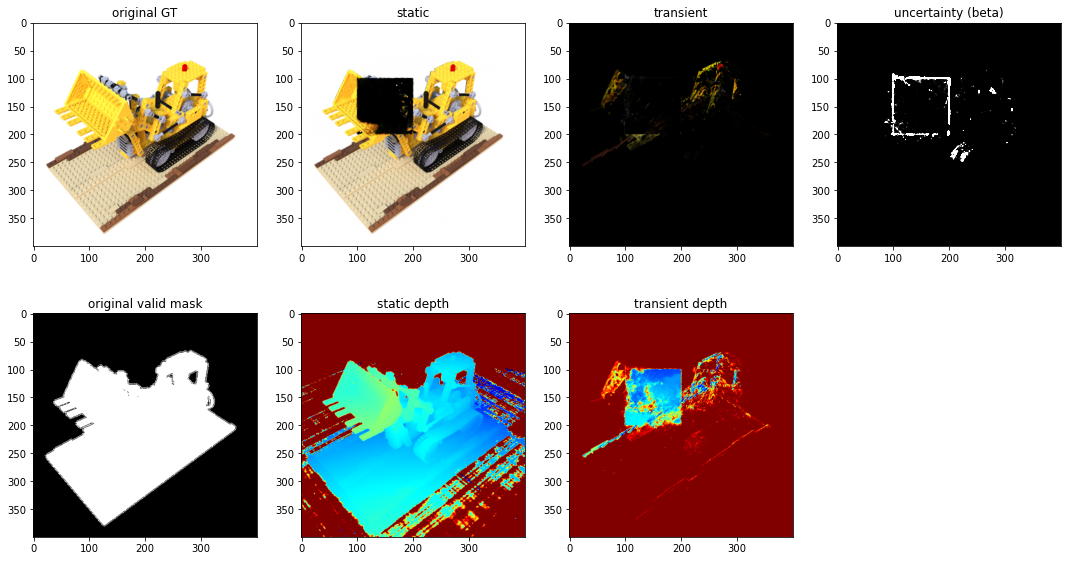

PSNR between original GT and static: 14.834516525268555


In [164]:
img_gt = sample['rgbs'].view(img_wh[1], img_wh[0], 3)
img_pred = results['rgb_fine'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
depth_pred = results['depth_fine'].view(img_wh[1], img_wh[0])

plt.subplots(figsize=(15, 8))
plt.tight_layout()
plt.subplot(231)
plt.title('GT')
plt.imshow(img_gt)
plt.subplot(232)
plt.title('pred')
plt.imshow(img_pred)
plt.subplot(233)
plt.title('depth')
plt.imshow(visualize_depth(depth_pred).permute(1,2,0))
plt.show()

print('PSNR between GT and pred:', metrics.psnr(img_gt, img_pred).item(), '\n')


if encode_transient:
    print('Decomposition--------------------------------------------' + 
          '---------------------------------------------------------' +
          '---------------------------------------------------------' + 
          '---------------------------------------------------------')
    img_gt_static = sample['original_rgbs'].view(img_wh[1], img_wh[0], 3)
    valid_mask_static = sample['original_valid_mask'].view(img_wh[1], img_wh[0])
    beta = results['beta'].view(img_wh[1], img_wh[0]).cpu().numpy()
    img_pred_static = results['rgb_fine_static'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
    img_pred_transient = results['rgb_fine_transient'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
    depth_pred_static = results['depth_fine_static'].view(img_wh[1], img_wh[0])
    depth_pred_transient = results['depth_fine_transient'].view(img_wh[1], img_wh[0])
    plt.subplots(figsize=(15, 8))
    plt.tight_layout()
    plt.subplot(241)
    plt.title('original GT')
    plt.imshow(img_gt_static)
    plt.subplot(242)
    plt.title('static')
    plt.imshow(img_pred_static)
    plt.subplot(243)
    plt.title('transient')
    plt.imshow(img_pred_transient)
    plt.subplot(244)
    plt.title('uncertainty (beta)')
    plt.imshow(beta-beta_min, cmap='gray', vmax=beta_min/100)
    plt.subplot(245)
    plt.title('original valid mask')
    plt.imshow(valid_mask_static, cmap='gray')
    plt.subplot(246)
    plt.title('static depth')
    plt.imshow(visualize_depth(depth_pred_static).permute(1,2,0))
    plt.subplot(247)
    plt.title('transient depth')
    plt.imshow(visualize_depth(depth_pred_transient).permute(1,2,0))
    plt.show()
    
    print('PSNR between original GT and static:',
          metrics.psnr(img_gt_static, img_pred_static).item())

# Test on 63th val image (same as the image in the paper Fig 13)

In [165]:
perturbation = ['occ']

valdataset = dataset_dict['blender'] \
          ('/home/zt16/code/priv-nerf/nerf-pytorch/data/NeRF_Data/nerf_synthetic/lego/',
           split='val',
           perturbation=perturbation,
           img_wh=img_wh)

In [169]:
sample = valdataset[1]
rays = sample['rays'].cuda()
ts = sample['ts'].cuda()

results = f(rays, ts)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


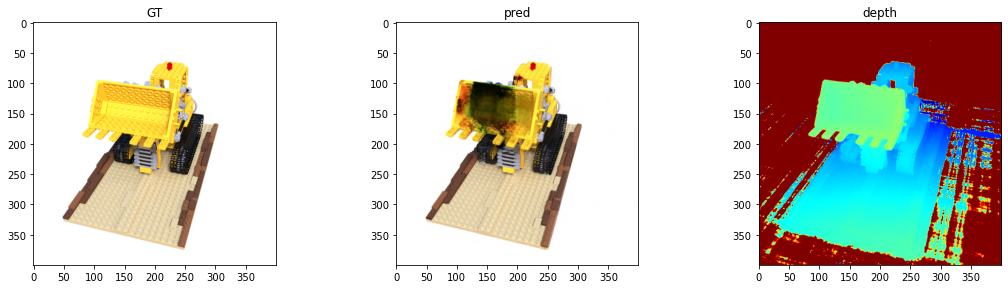

PSNR between GT and pred: 18.044336318969727 



In [170]:
img_gt = sample['rgbs'].view(img_wh[1], img_wh[0], 3)
img_pred = results['rgb_fine'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
depth_pred = results['depth_fine'].view(img_wh[1], img_wh[0])

plt.subplots(figsize=(15, 8))
plt.tight_layout()
plt.subplot(231)
plt.title('GT')
plt.imshow(img_gt)
plt.subplot(232)
plt.title('pred')
plt.imshow(img_pred)
plt.subplot(233)
plt.title('depth')
plt.imshow(visualize_depth(depth_pred).permute(1,2,0))
plt.show()

print('PSNR between GT and pred:', metrics.psnr(img_gt, img_pred).item(), '\n')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Decomposition-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


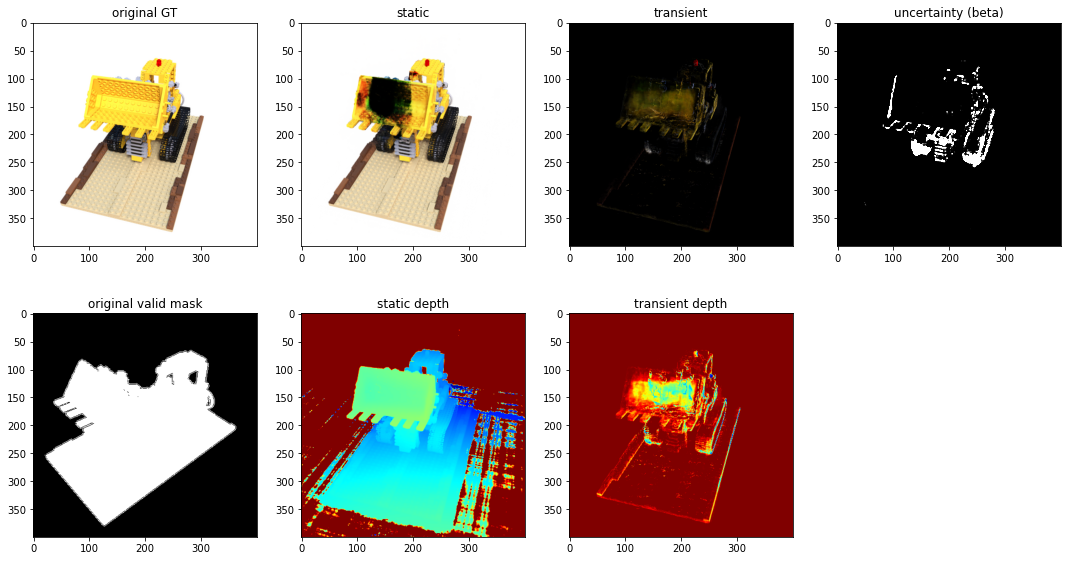

PSNR between original GT and static: 17.115966796875


In [171]:
if encode_transient:
    print('Decomposition--------------------------------------------' + 
          '---------------------------------------------------------' +
          '---------------------------------------------------------' + 
          '---------------------------------------------------------')
    img_gt_static = sample['rgbs'].view(img_wh[1], img_wh[0], 3)
    beta = results['beta'].view(img_wh[1], img_wh[0]).cpu().numpy()
    img_pred_static = results['rgb_fine_static'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
    img_pred_transient = results['rgb_fine_transient'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
    depth_pred_static = results['depth_fine_static'].view(img_wh[1], img_wh[0])
    depth_pred_transient = results['depth_fine_transient'].view(img_wh[1], img_wh[0])
    plt.subplots(figsize=(15, 8))
    plt.tight_layout()
    plt.subplot(241)
    plt.title('original GT')
    plt.imshow(img_gt_static)
    plt.subplot(242)
    plt.title('static')
    plt.imshow(img_pred_static)
    plt.subplot(243)
    plt.title('transient')
    plt.imshow(img_pred_transient)
    plt.subplot(244)
    plt.title('uncertainty (beta)')
    plt.imshow(beta-beta_min, cmap='gray', vmax=beta_min/100)
    plt.subplot(245)
    plt.title('original valid mask')
    plt.imshow(valid_mask_static, cmap='gray')
    plt.subplot(246)
    plt.title('static depth')
    plt.imshow(visualize_depth(depth_pred_static).permute(1,2,0))
    plt.subplot(247)
    plt.title('transient depth')
    plt.imshow(visualize_depth(depth_pred_transient).permute(1,2,0))
    plt.show()
    
    print('PSNR between original GT and static:',
          metrics.psnr(img_gt_static, img_pred_static).item())